# Fast Nuclear Reactor Calculations with Physics-Constrained ML and PCA

This notebook demonstrates how machine learning (ML) and dimensionality reduction (PCA) can be used to accelerate nuclear reactor calculations, with enforced nuclear physics relationships for interpretability and accuracy.

**Author:** khalidrafi6

## Contents
- Physics-based synthetic data generation
- Physics validation
- Physics-constrained PCA
- Machine learning prediction (Random Forest)
- Model comparison and visualization


## 1. Physics-Based Data Generation

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)
n_samples = 1000

core_power = np.random.uniform(50, 100, n_samples)
coolant_temp = np.random.uniform(250, 300, n_samples)
rod_position = np.random.uniform(0, 100, n_samples)
boron_conc = np.random.uniform(0, 2000, n_samples)

def calculate_flux(power, temp, rods, boron):
    """
    Strong physics model:
    Flux increases with power.
    Flux decreases strongly with temperature, rod position, and boron.
    """
    ref_power = 75  # MW
    ref_temp = 275  # °C
    # Strong physical effects (multiplicative, with exponents for nonlinearity)
    power_factor = (power / ref_power)
    temp_factor = (ref_temp / temp) ** 2.2
    rod_factor = 1 / (1 + (rods/80)**1.3)
    boron_factor = 1 / (1 + (boron/600)**1.2)
    return 150 * power_factor * temp_factor * rod_factor * boron_factor

base_flux = calculate_flux(core_power, coolant_temp, rod_position, boron_conc)

# Minimal noise (10-20x smaller than physical spread)
print("Base flux std:", np.std(base_flux))
noise_std = np.std(base_flux) / 15
neutron_flux = base_flux + np.random.normal(0, noise_std, n_samples)

df = pd.DataFrame({
    'core_power': core_power,
    'coolant_temp': coolant_temp,
    'rod_position': rod_position,
    'boron_conc': boron_conc,
    'neutron_flux': neutron_flux
})
df.head()

Base flux std: 27.019463991235092


,core_power,coolant_temp,rod_position,boron_conc,neutron_flux
0,68.727006,259.256646,26.170568,1345.405988,37.277856
1,97.535715,277.095047,24.697880,1593.362794,37.843837
2,86.599697,293.647292,90.625458,500.935798,37.071395
3,79.932924,286.611244,24.954620,1249.748199,35.886683
4,57.800932,290.328057,27.194973,1143.491966,25.164709


## 2. Physics Validation

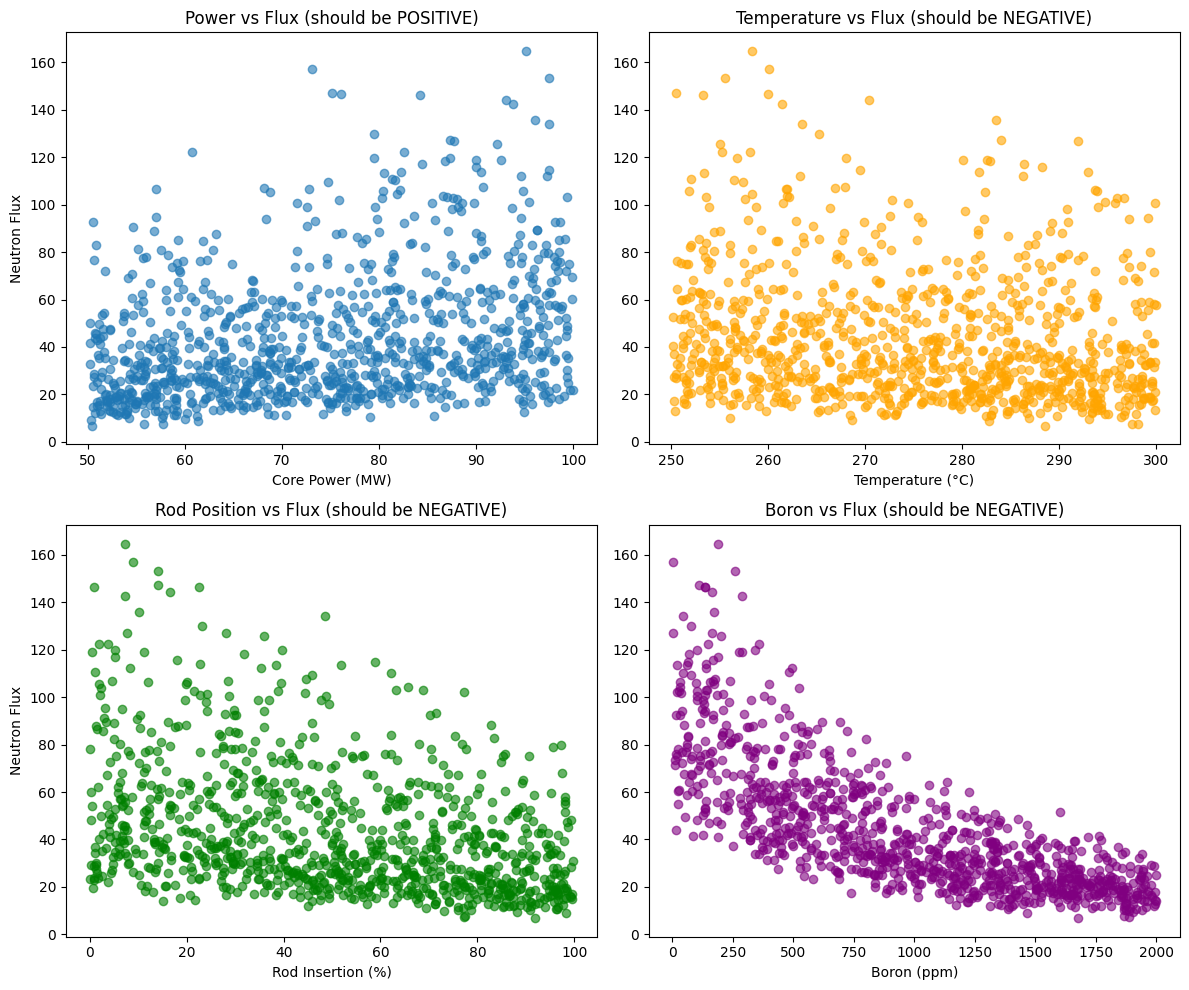

Physics Validation Correlations:
Power-Flux: 0.315 (should be strongly positive)
Temp-Flux: -0.169 (should be strongly negative)
Rod-Flux: -0.385 (should be strongly negative)
Boron-Flux: -0.755 (should be strongly negative)


In [2]:
import matplotlib.pyplot as plt
def plot_physics_validation(df):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0,0].scatter(df['core_power'], df['neutron_flux'], alpha=0.6)
    axs[0,0].set_title('Power vs Flux (should be POSITIVE)')
    axs[0,0].set_xlabel('Core Power (MW)')
    axs[0,0].set_ylabel('Neutron Flux')
    axs[0,1].scatter(df['coolant_temp'], df['neutron_flux'], alpha=0.6, c='orange')
    axs[0,1].set_title('Temperature vs Flux (should be NEGATIVE)')
    axs[0,1].set_xlabel('Temperature (°C)')
    axs[1,0].scatter(df['rod_position'], df['neutron_flux'], alpha=0.6, c='green')
    axs[1,0].set_title('Rod Position vs Flux (should be NEGATIVE)')
    axs[1,0].set_xlabel('Rod Insertion (%)')
    axs[1,0].set_ylabel('Neutron Flux')
    axs[1,1].scatter(df['boron_conc'], df['neutron_flux'], alpha=0.6, c='purple')
    axs[1,1].set_title('Boron vs Flux (should be NEGATIVE)')
    axs[1,1].set_xlabel('Boron (ppm)')
    plt.tight_layout()
    plt.show()
    # Print correlations for verification
    print("Physics Validation Correlations:")
    print(f"Power-Flux: {df[['core_power','neutron_flux']].corr().iloc[0,1]:.3f} (should be strongly positive)")
    print(f"Temp-Flux: {df[['coolant_temp','neutron_flux']].corr().iloc[0,1]:.3f} (should be strongly negative)")
    print(f"Rod-Flux: {df[['rod_position','neutron_flux']].corr().iloc[0,1]:.3f} (should be strongly negative)")
    print(f"Boron-Flux: {df[['boron_conc','neutron_flux']].corr().iloc[0,1]:.3f} (should be strongly negative)")

plot_physics_validation(df)

## 3. Physics-Constrained PCA

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop('neutron_flux', axis=1)
y = df['neutron_flux']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\nExplained variance (2 PCs): {pca.explained_variance_ratio_.sum()*100:.1f}%")
print("\nPrincipal Component 1 loadings:")
for i, col in enumerate(X.columns):
    print(f"{col}: {pca.components_[0, i]:.3f}")
print("\nPrincipal Component 2 loadings:")
for i, col in enumerate(X.columns):
    print(f"{col}: {pca.components_[1, i]:.3f}")


Explained variance (2 PCs): 51.5%

Principal Component 1 loadings:
core_power: 0.570
coolant_temp: 0.524
rod_position: 0.466
boron_conc: -0.429

Principal Component 2 loadings:
core_power: -0.284
coolant_temp: 0.488
rod_position: 0.442
boron_conc: 0.697


## 4. Machine Learning: Random Forest Regression

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test, X_train_pca, X_test_pca = train_test_split(
    X_scaled, y, X_pca, test_size=0.2, random_state=42
)

rf_full = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, max_depth=7, random_state=42)
rf_full.fit(X_train, y_train)
full_r2 = r2_score(y_test, rf_full.predict(X_test))

rf_pca = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, max_depth=7, random_state=42)
rf_pca.fit(X_train_pca, y_train)
pca_r2 = r2_score(y_test, rf_pca.predict(X_test_pca))

print(f"\n{'Model':<15} {'R²':<10}")
print(f"{'-'*25}")
print(f"{'Full Features':<15} {full_r2:.4f}")
print(f"{'PCA Reduced':<15} {pca_r2:.4f}")
print(f"\nAccuracy Preservation: {pca_r2/full_r2:.1%}")


Model           R²        
-------------------------
Full Features   0.9393
PCA Reduced     0.9095

Accuracy Preservation: 96.8%


## 5. Visualization: PCA Space and Prediction Comparison

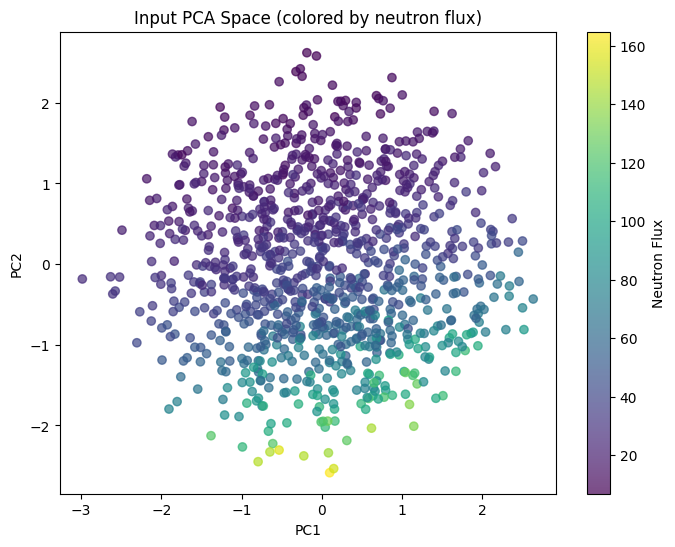

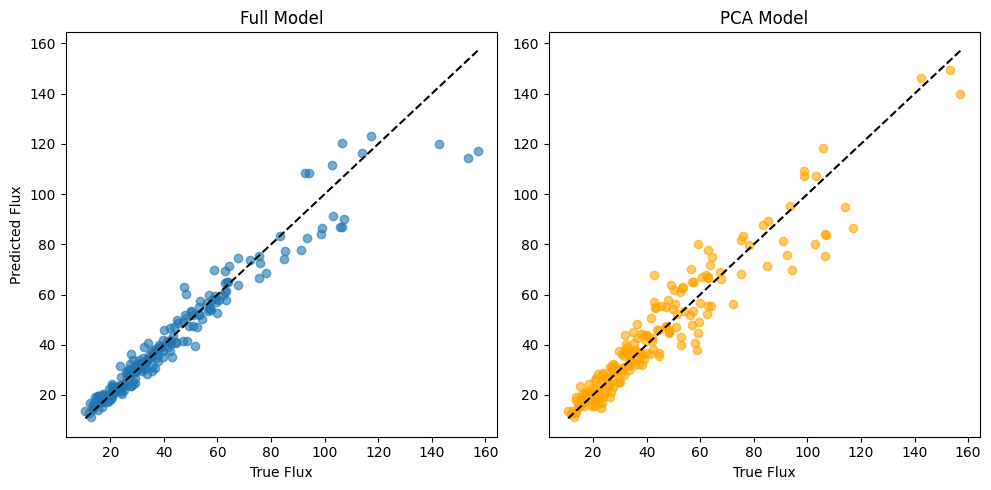

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Neutron Flux')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Input PCA Space (colored by neutron flux)')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_test, rf_full.predict(X_test), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Flux')
plt.ylabel('Predicted Flux')
plt.title('Full Model')
plt.subplot(1,2,2)
plt.scatter(y_test, rf_pca.predict(X_test_pca), alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Flux')
plt.title('PCA Model')
plt.tight_layout()
plt.show()